# Notebook to Calculate Facer Adhesion
***
## Directions:
1.) In the cell below enter the file path of the image in question to the right side of the equals sign. Ensure the path is contained in quotation marks

2.) Press Shift+Enter until you are prompted to enter the file path of the image in question.

3.) Enter the file path of the image.

4.) Continue to press Shift+Enter until all the cells have been run.
- ***Note - Some cells require a lot of computational power and may take a few seconds to run.***
- ***Note - Most cells will show a visualization of some kind.***

5.) Upon running the last cell and assuming the computer has finished its computations, a percent coverage metric will be presented.
***
## Enter file path of image in question to the right of the equal sign below. Ensure the path is contained within quatation marks.

In [1]:
path = "images/FacerAdhesion.jpg"

## Simply press shift+enter until you run final cell.
- ***Note - Some cells require a lot of computational power and may take a few seconds to run.***
- ***Note - Most cells will show a visualization of some kind.***

***
## Imports and Functions

In [2]:
#Imports
import cv2
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import mode
import matplotlib.pyplot as plt
from Utilties import show, show_gray, grab_contours


#Functions


#Function to flip labels in a clustered image
def flip_labels(clustered_image):
    return np.array([1 if i == 0 else 0 for i in clustered_image.ravel()]).reshape(clustered_image.shape)





#Function to ensure lighter pixels (in a grayscale image) are the pixels that correspond to cluster 1
def lighter_to_cluster_1(clustered_image, original_image):
    
    #Flatten the arrays
    clustered_points = clustered_image.ravel()
    original_points = original_image.ravel()
    
    #Calculate mean pixel intensity of each cluster
    cluster_0_mean = np.mean(original_points[clustered_points == 0])
    cluster_1_mean = np.mean(original_points[clustered_points == 1])
    
    #If cluster 1 mean < cluster 2 mean flip the labels
    #If cluster 1 mean > cluster 2 mean return the origina clustered image
    #Otherwise indicate means are equal and raise an error
    if cluster_1_mean < cluster_0_mean:
        return flip_labels(clustered_image)
    elif cluster_1_mean > cluster_0_mean:
        return clustered_image
    else:
        raise Exception("The corresponding pixel clusters of each image have the same average intensity.")

        
        
        
        
#Function to ensure foreground of a binary image is white
def check_forground(clustered_image):
    
    #Calculate midpoint of image and 1/8th of the image dimensions
    mid_row, eighth_row = clustered_image.shape[0]//2, clustered_image.shape[0]//8
    mid_col, eighth_col = clustered_image.shape[1]//2, clustered_image.shape[0]//8
    
    #Check the middle 25% of the image and ensure the mode value is 1 (white)
    mid_25 = clustered_image[mid_row-eighth_row:mid_row+eighth_row, mid_col-eighth_col:mid_col+eighth_col]
    
    #Check the mode
    #If the mode is not 1, flip the labels
    if int(mode(mid_25.ravel())[0][0]) != 1:
        clustered_image = flip_labels(clustered_image)
        
    #Return the binary image ensuring uint8 datatype
    return clustered_image.astype("uint8")





#Function to binarize a colored image with KMeans
def binarize_color(image):
    
    #Reshape the channels
    channels = image.reshape(-1,3)
    
    #Cluster the channels
    binarizer = KMeans(n_clusters = 2).fit(channels)
    
    #Reshape the labels into the shape of the image other than the color channels -> This is the binary image
    binary_image = binarizer.labels_.reshape(image.shape[:2]).astype("uint8")
    
    #Check forground
    binary_image = check_forground(binary_image)
    
    #Visualize
    show_gray(binary_image, "Binarized")
    
    #Return the binary image ensuring "uint8 datatpe"
    return binary_image





#Function to binarize a grayscale image with KMeans
def binarize_gray(image):
    
    #Cluster the flattened image
    binarizer = KMeans(n_clusters = 2).fit(image.ravel().reshape(-1,1))
    
    #Reshape the labels into the shape of the original image
    binary_image = binarizer.labels_.reshape(image.shape).astype("uint8")
    
    #Check forground
    binary_image = check_forground(binary_image)
    
    #Visualize
    show_gray(binary_image, "Binarized")
    
    #Return the binary image
    return binary_image

***
## Show the Original Image

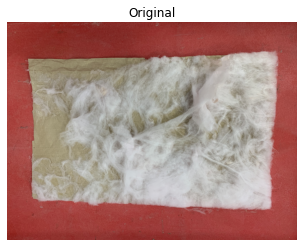

In [3]:
image = cv2.imread(path)
show(image, "Original")

***
## Step 1: Apply Strong Median Blur
- Kernel size of 101
- Removes many details and allows rectangular facer to be more obvious which allows for better contour detection

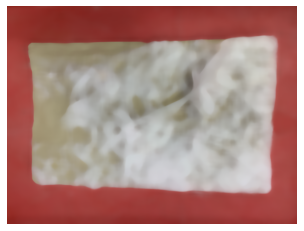

In [4]:
#Start with a solid median blur
blurred = cv2.medianBlur(image, 101)
show(blurred)

***
## Step 2: Binarize The Image
- Binary image necessary for contour detection

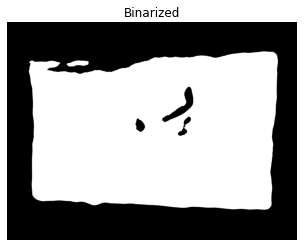

In [5]:
#Binarize
binary = binarize_color(blurred)

***
## Step 3: Create Mask
### 3.1 Contour Detection
- Contour the binary image and grab contour which contains the most area
- Grab only external contours, sort the contours by decreasing enclosing area, and slice the contour with the largest enclosing area

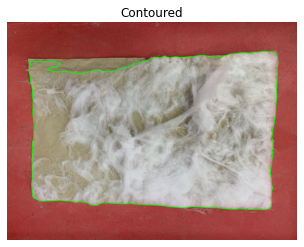

In [6]:
#Detect contours
cnts = grab_contours(cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))

#Order the contours by decreasing enclosing area and grab the contour which contains the longest area
cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

#Draw the contour of interest
show(cv2.drawContours(image.copy(), [cnt], -1, (0,255,0), 10), "Contoured")

### 3.2 Convex Hull
- Calculate a convex hull to approximate the rectangular shape of facer

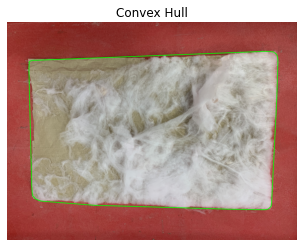

In [7]:
#Calculate convex hull
hull = cv2.convexHull(cnt)

#Draw Convex Hull
show(cv2.drawContours(image.copy(), [hull], -1, (0,255,0), 10), "Convex Hull")

### 3.3 Create and Apply Mask
- Create mask out of convex hull

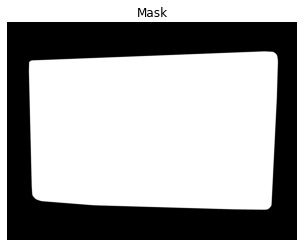

In [8]:
#Draw the contour filled on a zeros array in same shape as original image
mask = np.zeros(image.shape[:2], dtype = "uint8")
mask = cv2.drawContours(mask, [hull], -1, 1, -1)
show_gray(mask, "Mask")

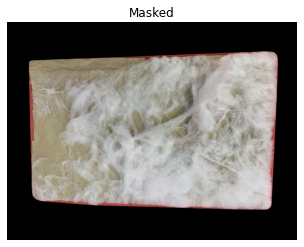

In [9]:
#Apply Mask
masked = cv2.bitwise_and(image, image, mask = mask)
show(masked, "Masked")

***
## Step 4: Cluster Out Insulation off Facer
- Turn maked image to grayscale
- Apply histogram equalization
- Binarize with KMeans

### 4.1 Make Masked Image Grayscale

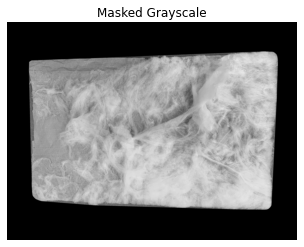

In [10]:
gray = cv2.cvtColor(masked, cv2.COLOR_BGR2GRAY)
show_gray(gray, "Masked Grayscale")

### 4.2 Histogram Equalization
- Apply Histogram Equalization for better contrast between insulation and facer

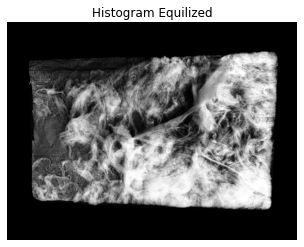

In [11]:
equilized = cv2.equalizeHist(gray)
show_gray(equilized, "Histogram Equilized")

### 4.3 Apply Clustering to Segment Insulation

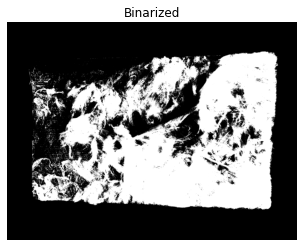

In [12]:
#Binarize and ensure cluster 1 corresponds to lighter pixel values
insulation = binarize_gray(equilized)
insulation = lighter_to_cluster_1(insulation, equilized)

***
## Step 5: Calculate Percent Coverage
- Sum up white pixels in mask - (1)
- Sum up white pixels in segmented insulation - (2)
- Take ratio of (2)/(1)
- Ensure that mask and insulation segment are binary

In [13]:
coverage = np.sum(insulation)/np.sum(mask)*100
print("Percent Coverage = {:.02f}%".format(coverage))

Percent Coverage = 63.33%
